# 38616 - HW1: Implement a Neural Network from scratch

Natalie Pham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Optional, List, Tuple, Dict


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
class Transform(object):
    """
    This is the base class. You do not need to change anything.
    Read the comments in this class carefully.
    """
    def __init__(self):
        """
        Initialize any parameters
        """
        pass

    def forward(self, x):
        """
        x should be passed as column vectors
        """
        pass

    def backward(self, grad_wrt_out):
        """
        Compute and save the gradients wrt the parameters for step()
        Return grad_wrt_x which will be the grad_wrt_out for previous Transform
        """
        pass

    def step(self):
        """
        Apply gradients to update the parameters
        """
        pass

    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        pass
    
class ReLU(Transform):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (indim, batch_size)
        """
        self.x = x
        return(torch.maximum(x, torch.tensor(0.0)))

    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        """
        grad_wrt = torch.where(self.x > 0, grad_wrt_out, torch.tensor(0.0)) # np.where(x > 0, grad_wrt_out, 0)
        return(grad_wrt)
    
class LinearMap(Transform):
    def __init__(self, indim, outdim, lr=0.001):
        """
        indim: input dimension
        outdim: output dimension
        lr: learning rate
        """
        super(LinearMap, self).__init__()
        self.weights = 0.01 * torch.rand((outdim, indim), dtype=torch.float64, requires_grad=True, device=device)
        self.bias = 0.01 * torch.rand((outdim, 1), dtype=torch.float64, requires_grad=True, device=device)
        self.lr = lr


    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (outdim, batch_size)
        """
        self.x = x
        output = torch.add(torch.matmul(self.weights, x), self.bias)
        return(output)


    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        return shape (indim, batch_size)
        """
        # compute grad_wrt_weights
        grad_wrt_weights = torch.matmul(grad_wrt_out, self.x.T)
        self.grad_wrt_weights = grad_wrt_weights
        
        # compute grad_wrt_bias
        grad_wrt_bias = torch.sum(grad_wrt_out, axis=1, keepdim=True)
        self.grad_wrt_bias = grad_wrt_bias
        
        # compute grad_wrt_input
        grad_wrt_input = torch.matmul(self.weights.T, grad_wrt_out)

        return grad_wrt_input


    def step(self):
        """
        apply gradients calculated by backward() to update the parameters
        """
        self.weights = self.weights - self.lr * self.grad_wrt_weights
        self.bias = self.bias - self.lr * self.grad_wrt_bias

    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        self.grad_wrt_weights = None
        self.grad_wrt_bias = None
        
class SoftmaxCrossEntropyLoss(object):
    def forward(self, logits, labels):
        """
        logits are pre-softmax scores, labels are one-hot labels of given inputs
        logits and labels are in the shape of (num_classes, batch_size)
        returns loss as a scalar (i.e. mean value of the batch_size loss)
        """
        self.logits = logits
        self.labels = labels

        exp_logits = torch.exp(self.logits - torch.max(logits, axis=0, keepdim=True).values)
        softmax = exp_logits / torch.sum(exp_logits, axis=0, keepdim=True)
        self.softmax = softmax
        
        self.loss = -torch.sum(self.labels * torch.log(self.softmax)) / logits.shape[1]
        return self.loss
    
    def backward(self):
        """
        return grad_wrt_logits shape (num_classes, batch_size)
        (don't forget to divide by batch_size because your loss is a mean)
        """
        grad_wrt_logits = -(self.labels - self.softmax) / self.labels.shape[1]
        return grad_wrt_logits
        
    
    def getAccu(self):
        """
        return accuracy here
        """        
        pred = torch.argmax(self.softmax, dim=0)
        target = torch.argmax(self.labels, dim=0)
        accuracy = torch.mean(torch.eq(pred, target).to(torch.float)) #/ self.labels.shape[0]
        return accuracy   
    
class SingleLayerMLP(Transform):
    """constructing a single layer neural network with the previous functions"""
    def __init__(self, indim, outdim, hidden_layer=100, lr=0.001):
        super(SingleLayerMLP, self).__init__()
        self.linear1 = LinearMap(indim, hidden_layer, lr)
        self.relu = ReLU()
        self.linear2 = LinearMap(hidden_layer, outdim, lr)
        self.softmax_loss = SoftmaxCrossEntropyLoss()
        
        
    def forward(self, x):
        """
        x shape (indim, batch_size)
        return the presoftmax logits shape(outdim, batch_size)
        """
        fwd_out = self.linear1.forward(x)
        fwd_out = self.relu.forward(fwd_out)
        fwd_out = self.linear2.forward(fwd_out)
        
        return fwd_out
    

    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        calculate the gradients wrt the parameters
        """
        grad_wrt_out = self.linear2.backward(grad_wrt_out)
        grad_wrt_out = self.relu.backward(grad_wrt_out)
        grad_wrt_out = self.linear1.backward(grad_wrt_out)
        
        return grad_wrt_out
    
    def step(self):
        """update model parameters"""
        self.linear1.step()
        self.linear2.step()
        
    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        self.linear1.zerograd()
        self.linear2.zerograd()
        
class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length

def labels2onehot(labels: torch.tensor):
    return torch.tensor([[i==lab for i in range(2)] for lab in labels], dtype=torch.float)

In [3]:
if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need plot the loss and accuracies during the training process and test process. 
    """

    indim = 10
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 200

    #dataset
    Xtrain = np.loadtxt("data/XTrain.txt", delimiter="\t")
    Ytrain = np.loadtxt("data/yTrain.txt", delimiter="\t").astype(int)
    m1, n1 = Xtrain.shape
    print(m1, n1)
    train_ds = DS(Xtrain, Ytrain)
    train_loader = DataLoader(train_ds, batch_size=batch_size)

    Xtest = np.loadtxt("data/XTest.txt", delimiter="\t")
    Ytest = np.loadtxt("data/yTest.txt", delimiter="\t").astype(int)
    m2, n2 = Xtest.shape
    print(m1, n2)
    test_ds = DS(Xtest, Ytest)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    #construct the model
    model = SingleLayerMLP(indim, outdim, hidden_dim, lr)

    # Define the loss function
    loss_fnc = SoftmaxCrossEntropyLoss()
    
    #construct the training process
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    for epoch in range(epochs):
        total_train_loss = 0
        total_train_acc = 0 
        total_test_loss = 0
        total_test_acc = 0
        
        train_samples = 0
        test_samples = 0
        # Train the model
        for x, y in train_loader:
            x = torch.tensor(x).T 
            y = torch.tensor(labels2onehot(y))
            train_samples += x.shape[1]
            
            # get train loss and accuracy
            train_loss = loss_fnc.forward(model.forward(x), y.T)
            total_train_loss += train_loss * x.shape[1]
            train_acc = loss_fnc.getAccu()
            total_train_acc += train_acc * x.shape[1]
            
            # backpropagation
            grad_wrt_out = loss_fnc.backward()
            model.backward(grad_wrt_out)
            model.step()
            
            # zero the gradients
            model.zerograd()
        
        # print(train_samples)
        avg_train_loss = total_train_loss / train_samples 
        train_losses.append(avg_train_loss)
        avg_train_acc = total_train_acc / train_samples 
        train_accs.append(avg_train_acc)
        
        
        # Validate the model
        for x, y in test_loader:
            x = torch.tensor(x).T 
            y = torch.tensor(labels2onehot(y))
            test_samples += x.shape[1]
            
            # get test loss and accuracy
            test_loss = loss_fnc.forward(model.forward(x), y.T)
            total_test_loss += test_loss * x.shape[1]
            test_acc = loss_fnc.getAccu()
            total_test_acc += test_acc * x.shape[1]
            
            
        avg_test_loss = total_test_loss / test_samples
        test_losses.append(avg_test_loss)
        avg_test_acc = total_test_acc / test_samples 
        test_accs.append(avg_test_acc)
        
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f}, Test Loss={avg_test_loss:.4f}, Test Acc={avg_test_acc:.4f}")

500 10
500 10
Epoch 1: Train Loss=0.6931, Train Acc=0.5000, Test Loss=0.6930, Test Acc=0.5000
Epoch 2: Train Loss=0.6929, Train Acc=0.5000, Test Loss=0.6928, Test Acc=0.5000


C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\thanh\Anaconda3\envs\CMU\lib\site-packages\ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach()

Epoch 3: Train Loss=0.6927, Train Acc=0.5000, Test Loss=0.6927, Test Acc=0.5000
Epoch 4: Train Loss=0.6925, Train Acc=0.5000, Test Loss=0.6925, Test Acc=0.5000
Epoch 5: Train Loss=0.6924, Train Acc=0.5000, Test Loss=0.6923, Test Acc=0.5000
Epoch 6: Train Loss=0.6922, Train Acc=0.5000, Test Loss=0.6922, Test Acc=0.5000
Epoch 7: Train Loss=0.6920, Train Acc=0.5000, Test Loss=0.6920, Test Acc=0.5000
Epoch 8: Train Loss=0.6918, Train Acc=0.5000, Test Loss=0.6918, Test Acc=0.5000
Epoch 9: Train Loss=0.6916, Train Acc=0.5000, Test Loss=0.6916, Test Acc=0.5000
Epoch 10: Train Loss=0.6913, Train Acc=0.5000, Test Loss=0.6914, Test Acc=0.5000
Epoch 11: Train Loss=0.6911, Train Acc=0.5000, Test Loss=0.6912, Test Acc=0.5000
Epoch 12: Train Loss=0.6908, Train Acc=0.5000, Test Loss=0.6909, Test Acc=0.5000
Epoch 13: Train Loss=0.6906, Train Acc=0.5000, Test Loss=0.6907, Test Acc=0.5000
Epoch 14: Train Loss=0.6903, Train Acc=0.5000, Test Loss=0.6904, Test Acc=0.5000
Epoch 15: Train Loss=0.6900, Train 

Epoch 106: Train Loss=0.3257, Train Acc=0.9420, Test Loss=0.3364, Test Acc=0.9400
Epoch 107: Train Loss=0.3222, Train Acc=0.9420, Test Loss=0.3331, Test Acc=0.9400
Epoch 108: Train Loss=0.3188, Train Acc=0.9420, Test Loss=0.3298, Test Acc=0.9350
Epoch 109: Train Loss=0.3154, Train Acc=0.9440, Test Loss=0.3266, Test Acc=0.9350
Epoch 110: Train Loss=0.3121, Train Acc=0.9440, Test Loss=0.3234, Test Acc=0.9350
Epoch 111: Train Loss=0.3088, Train Acc=0.9460, Test Loss=0.3203, Test Acc=0.9350
Epoch 112: Train Loss=0.3056, Train Acc=0.9460, Test Loss=0.3173, Test Acc=0.9350
Epoch 113: Train Loss=0.3025, Train Acc=0.9460, Test Loss=0.3143, Test Acc=0.9350
Epoch 114: Train Loss=0.2994, Train Acc=0.9460, Test Loss=0.3114, Test Acc=0.9350
Epoch 115: Train Loss=0.2964, Train Acc=0.9500, Test Loss=0.3085, Test Acc=0.9350
Epoch 116: Train Loss=0.2934, Train Acc=0.9500, Test Loss=0.3057, Test Acc=0.9350
Epoch 117: Train Loss=0.2905, Train Acc=0.9500, Test Loss=0.3029, Test Acc=0.9350
Epoch 118: Train

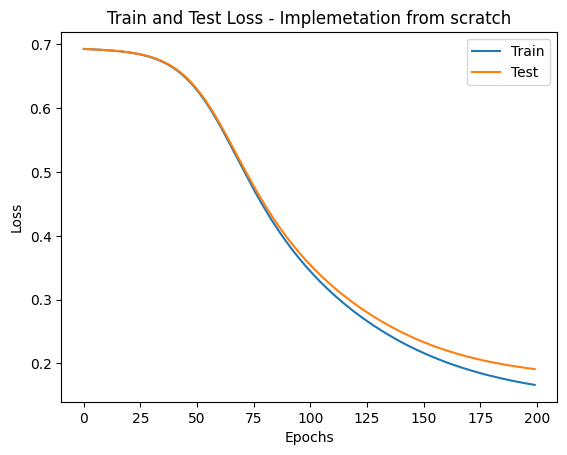

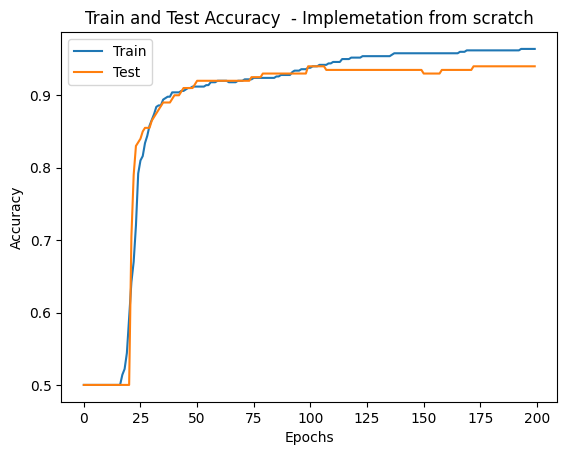

In [4]:
# plot training and testing losses
plt.plot(np.arange(epochs), torch.tensor(train_losses).detach().numpy(), label="Train")
plt.plot(np.arange(epochs), torch.tensor(test_losses).detach().numpy(), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train and Test Loss - Implemetation from scratch')
plt.legend()
plt.savefig('nn_scratch_loss.png')
plt.show()

# plot training and testing accuracies
plt.plot(np.arange(epochs), np.array(train_accs), label="Train")
plt.plot(np.arange(epochs), np.array(test_accs), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Train and Test Accuracy  - Implemetation from scratch')
plt.legend()
plt.savefig('nn_scratch_acc.png')
plt.show()